In [1]:
############################################
# Section 0

# Matplotlib Inline
%matplotlib inline

# Import libraries
import os
import shutil
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re # regular expressions
import collections
import pandas as pd
from scipy import stats
import subprocess

# Import function file
from ic_functions_final import *

# Change pd settings to display all dataframe content
pd.set_option('display.max_rows',None)

In [2]:
## Section 1: Gene Identifiers
geneID,NametoIDs,NametoFBid = geneIDdictionary('Datasets/fbgn_annotation_ID_fb_2016_05.tsv')

In [3]:
## Section 2: Read in input files
# Read in the AP/DV enhancers and alphabetize them by enhancer name
AP_enhancers = readFASTA('Datasets/ap_enc_12.fa','sequences',0,geneID,re.compile('([\w\-]+)_mel'))
od_AP_enhancers = collections.OrderedDict(sorted(AP_enhancers.items()))
DV_enhancers = readFASTA('Datasets/dv_enc_12.fa','sequences',0,geneID,re.compile('([\w\-]+)_mel'))
od_DV_enhancers = collections.OrderedDict(sorted(DV_enhancers.items()))
# Read in the AP/DV TFs
AP_DV_TFs = readFASTA('Datasets/Modified/AP_DV_TFs.txt','list_str',0,geneID,0)

# Read in minimized Vienna Tile (VT) enhancers
minVT_enhancers_ALL = readFASTA('Datasets/Modified/VTminimizedOnly_dm6.fa','sequences',0,geneID,0)
minVT_enhancers = readFASTA('Datasets/Modified/VTminimizedbyStage.txt','list_str',0,geneID,0)
# Read in TFs over embryogenesis
TF_stage = readFASTA('Datasets/Modified/TFs_by_stage.txt','list_str',0,0,0)
TF_stage_ALL = list(set([TF for stage in TF_stage for TF in TF_stage[stage]]))

In [4]:
## Section 3: Read in the PFMs
PFM,checkFBgn = readFASTA('Datasets/Modified/PFMs.fasta','PWM','v',geneID,regexKey=0,nameasis=1,fullname=0)
heterodimers = readFASTA('Datasets/Modified/heterodimers.txt','sequences',0,geneID,0)

# Create the information content dictionary
IC = ICdictionary(PFM)

# Set the ln(p-value) cutoff for determining real TFBSs
perc = 75
lnp_data = readFASTA('patserAnalysis/lnp_data.txt','list_num',0,geneID,0)
lnp_cutoff = dict(zip(lnp_data.keys(),[np.percentile(x,perc) for x in lnp_data.values()]))

In [5]:
## Section 4: Look at tradeoffs in enhancer architecture
# Tradeoffs in Enhancer Architecture: Multiple Is
w = range(200,3300,100)
N = 1.755*math.pow(10,8)
m = 1
p = [math.pow(2,-np.percentile(IC.values(),_)) for _ in [75,50,25]]
k = 1
temp_nTFs = []

for p0 in p:
    temp = []
    k = k/2
    for w0 in w:
        error = 1
        while abs(error) > 0.001:
            error = 1 - math.pow(m*p0*w0,k)/math.gamma(k+1)*math.exp(-(m*p0*w0))*N
            k = k + 0.00001
        temp.append(k)
        k = math.floor(k)
    temp_nTFs.append(temp)

# Tradeoffs in Enhancer Architecture: Multiple Ns
nTFs = [] # first list for multiple Is; second list for multiple Ns
nTFs.append(temp_nTFs) # add the first list
temp_nTFs = [] # reinitialize temp_nTFs

N = [175.5*math.pow(10,6),19.4*math.pow(10,6),4.1*math.pow(10,6)]
#Note: here p or p0 is 5.65 bits

for N0 in N:
    temp = []
    k = 1
    for w0 in w:
        error = 1
        while abs(error) > 0.001:
            error = 1 - math.pow(m*p0*w0,k)/math.gamma(k+1)*math.exp(-(m*p0*w0))*N0
            k = k + 0.00001
        temp.append(k)
        k = math.floor(k)
    temp_nTFs.append(temp)
nTFs.append(temp_nTFs) # add the second list

In [6]:
print w[8],nTFs[1][2][8]

1000 13.29493


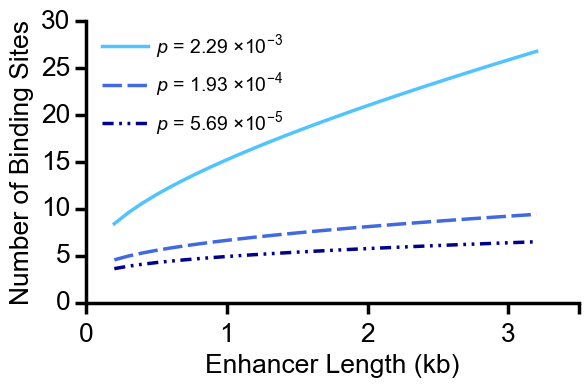

In [7]:
## Figure 1B: Tradeoffs between Enhancer Length, Number of TFBSs, and Average Information Content
## Note: Here, varying average information content
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(12/adj)]
linewidth = 2.5

fig, ax1 = plt.subplots()

w = range(200,3300,100)
i = 0
ax1.plot([float(x)/1000 for x in w],nTFs[i][2],c='#51C3FF',lw=linewidth,linestyle='-')
ax1.plot([float(x)/1000 for x in w],nTFs[i][1],c='royalblue',lw=linewidth,dashes=[14,4])#'--')
ax1.plot([float(x)/1000 for x in w],nTFs[i][0],c = 'darkblue',lw=linewidth,dashes=[8, 4, 2, 4, 2, 4])

# Add x-,y-labels
ax1.set_xlabel('Enhancer Length (kb)',fontsize=font[2])
ax1.set_ylabel('Number of Binding Sites',fontsize=font[2])

# Adjust x-ticks
plt.xticks([0,1,2,3,3.5], [0,1,2,3])

# Add legend 
# ax1.legend(('I = 8.77 bits','I = 12.34 bits','I = 14.10 bits'), loc = 2,frameon=False,handlelength=3,borderaxespad=0.1,handletextpad=0.1,fontsize=font[3])
ax1.legend((r'$p$ = 2.29 $\times 10^{-3}$',r'$p$ = 1.93 $\times 10^{-4}$',r'$p$ = 5.69 $\times 10^{-5}$'), loc = 2,frameon=False,handlelength=3,borderaxespad=0.1,handletextpad=0.1,fontsize=font[3])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

if not os.path.exists('Figures'):
	os.makedirs('Figures')
    
plt.savefig('Figures/Figure 1B-Tradeoff between parameters(I).svg',transparent=True)

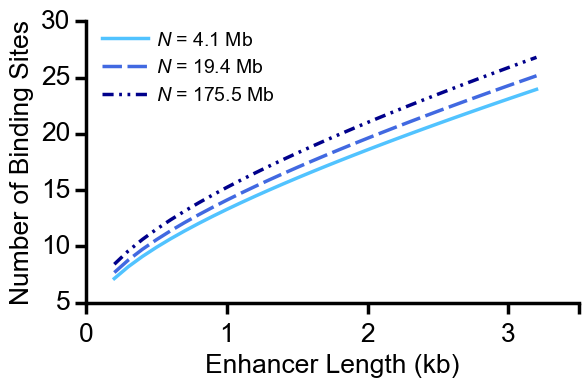

In [8]:
## Figure 1C: Tradeoffs between Enhancer Length, Number of TFBSs, and Average Information Content
## Note: Here, varying effective genome length or accessible regions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(12/adj)]
linewidth = 2.5

fig, ax1 = plt.subplots()

w = range(200,3300,100)
i = 1
ax1.plot([float(x)/1000 for x in w],nTFs[i][2],c='#51C3FF',lw=linewidth,linestyle='-')
ax1.plot([float(x)/1000 for x in w],nTFs[i][1],c='royalblue',lw=linewidth,dashes=[14,4])
ax1.plot([float(x)/1000 for x in w],nTFs[i][0],c = 'darkblue',lw=linewidth,dashes=[8, 4, 2, 4, 2, 4])

# Hide these grid behind plot objects
ax1.set_axisbelow(True)

# Add x-,y-labels
ax1.set_xlabel('Enhancer Length (kb)',fontsize=font[2])
ax1.set_ylabel('Number of Binding Sites',fontsize=font[2])

# Adjust x-ticks
plt.xticks([0,1,2,3,3.5], [0,1,2,3])

# Add legend
ax1.legend((r'$N$ = 4.1 Mb',r'$N$ = 19.4 Mb',r'$N$ = 175.5 Mb'), loc = 2,frameon=False,handlelength=3,borderaxespad=0.1,handletextpad=0.1,fontsize=font[3])

# ax1.margins(0.01)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

if not os.path.exists('Figures'):
	os.makedirs('Figures')

plt.savefig('Figures/Figure 1C-Tradeoff between parameters(N).svg',transparent=True)

In [5]:
## Section 5a: Analyze AP/DV enhancers - calculate length, number of binding sites, and av motif hit probability of enhancers
od_len_ap_enhancer = createSeqIN(od_AP_enhancers,0,0,os.getcwd(),'AP_enhancers_mel',1,0)
od_len_dv_enhancer = createSeqIN(od_DV_enhancers,0,0,os.getcwd(),'DV_enhancers_mel',1,0)
runPatser(os.getcwd(),'AP_enhancers_mel',AP_DV_TFs['AP'])
runPatser(os.getcwd(),'DV_enhancers_mel',AP_DV_TFs['DV'])
ap_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['AP'],'AP_enhancers_mel',lnp_cutoff,'AP',perc,'.txt')
dv_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['DV'],'DV_enhancers_mel',lnp_cutoff,'DV',perc,'.txt')
od_av_ap_enhancer_IC, od_ap_enhancer_nTFs, od_ap_enhancer_TF_counts \
 = PatserAnalysis(ap_patser_output,'all',AP_DV_TFs['AP'],heterodimers,IC)
od_av_dv_enhancer_IC, od_dv_enhancer_nTFs, od_dv_enhancer_TF_counts \
 = PatserAnalysis(dv_patser_output,'all',AP_DV_TFs['DV'],heterodimers,IC)

Done: bcd
Done: cad
Done: fkh
Done: gt
Done: hkb
Done: hb
Done: kni
Done: knrl
Done: Kr
Done: oc
Done: tll
Done: D
Done: eve
Done: ftz
Done: h
Done: opa
Done: prd
Done: run
Done: slp1
Done: slp2
Done: sob
Done: odd
Done: bowl
Done: da
Done: dl
Done: brk
Done: Mad
Done: Med
Done: shn
Done: sna
Done: twi
Done: zen
Done: zen2
bcd
cad
fkh
gt
hkb
hb
kni
knrl
Kr
oc
tll
D
eve
ftz
h
opa
prd
run
slp1
slp2
sob
odd
bowl
da
dl
brk
Mad
Med
shn
sna
twi
zen
zen2


In [15]:
# Try with all AP and DV TFs
od_len_ap_enhancer = createSeqIN(od_AP_enhancers,0,0,'patserIn/AP_enhancers_mel',0,0)
od_len_dv_enhancer = createSeqIN(od_DV_enhancers,0,0,'patserIn/DV_enhancers_mel',0,0)
runPatser(os.getcwd(),'AP_enhancers_mel',AP_DV_TFs['DV'])
runPatser(os.getcwd(),'DV_enhancers_mel',AP_DV_TFs['AP'])
ap_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['AP']+AP_DV_TFs['DV'],'AP_enhancers_mel',lnp_cutoff,'AP',perc,'.txt')
dv_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['AP']+AP_DV_TFs['DV'],'DV_enhancers_mel',lnp_cutoff,'DV',perc,'.txt')
od_av_ap_enhancer_IC, od_ap_enhancer_nTFs, od_ap_enhancer_TF_counts \
 = PatserAnalysis(ap_patser_output,'all',AP_DV_TFs['AP']+AP_DV_TFs['DV'],heterodimers,IC)
od_av_dv_enhancer_IC, od_dv_enhancer_nTFs, od_dv_enhancer_TF_counts \
 = PatserAnalysis(dv_patser_output,'all',AP_DV_TFs['AP']+AP_DV_TFs['DV'],heterodimers,IC)

Done: da
Done: dl
Done: brk
Done: Mad
Done: Med
Done: shn
Done: sna
Done: twi
Done: zen
Done: zen2
Done: bcd
Done: cad
Done: fkh
Done: gt
Done: hkb
Done: hb
Done: kni
Done: knrl
Done: Kr
Done: oc
Done: tll
Done: D
Done: eve
Done: ftz
Done: h
Done: opa
Done: prd
Done: run
Done: slp1
Done: slp2
Done: sob
Done: odd
Done: bowl
bcd
cad
fkh
gt
hkb
hb
kni
knrl
Kr
oc
tll
D
eve
ftz
h
opa
prd
run
slp1
slp2
sob
odd
bowl
da
dl
brk
Mad
Med
shn
sna
twi
zen
zen2
bcd
cad
fkh
gt
hkb
hb
kni
knrl
Kr
oc
tll
D
eve
ftz
h
opa
prd
run
slp1
slp2
sob
odd
bowl
da
dl
brk
Mad
Med
shn
sna
twi
zen
zen2


AP Enhancer Length Percentiles:
5th percentile: 397.1 bp
25th percentile: 920.75 bp
50th percentile: 1289.0 bp
75th percentile: 1614.0 bp
95th percentile: 2415.8 bp
Autoregulatory Enhancer Lengths:
ftz-up: 1787 bp
ftz-zebra: 738 bp
gt-minus1: 1239 bp


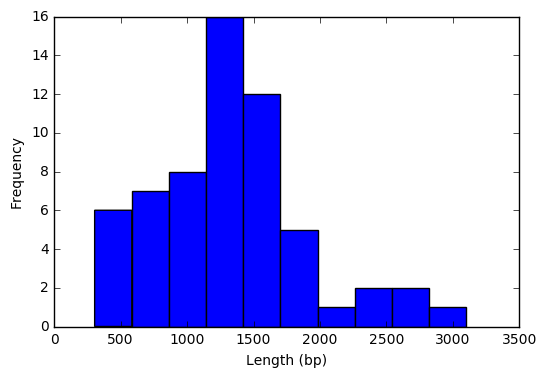

In [6]:
# Check autoregulatory enhancers
autoregulatory = ['ftz-up','ftz-zebra','gt-minus1']
percentiles = [5,25,50,75,95]
print 'AP Enhancer Length Percentiles:'
for p in percentiles:
    print '%sth percentile: %s bp' %(p,np.percentile(od_len_ap_enhancer.values(),p))
print 'Autoregulatory Enhancer Lengths:'
for enhancer in autoregulatory:
    print '%s: %s bp' %(enhancer,od_len_ap_enhancer[enhancer])
plt.hist(od_len_ap_enhancer.values(), bins = 10)
plt.xlabel('Length (bp)')
plt.ylabel('Frequency')
plt.show()

Number of TF Binding Sites in AP Enhancers Percentiles:
5th percentile: 10.9
25th percentile: 26.0
50th percentile: 47.0
75th percentile: 58.0
95th percentile: 87.1
Number of TF Bingin Sites in Autoregulatory Enhancers:
ftz_up: 55
ftz_zebra: 23
gt_minus1: 26


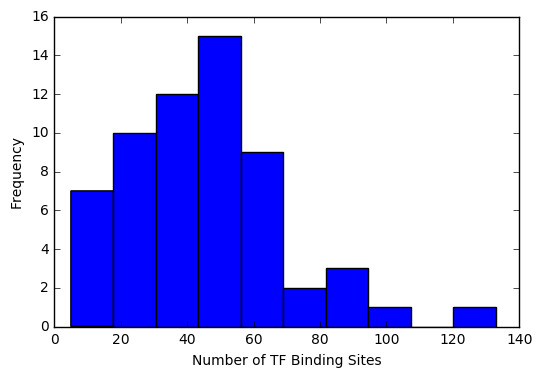

In [7]:
autoregulatory = ['ftz_up','ftz_zebra','gt_minus1']
percentiles = [5,25,50,75,95]
print 'Number of TF Binding Sites in AP Enhancers Percentiles:'
for p in percentiles:
    print '%sth percentile: %s' %(p,np.percentile(od_ap_enhancer_nTFs.values(),p))
print 'Number of TF Bingin Sites in Autoregulatory Enhancers:'
for enhancer in autoregulatory:
    print '%s: %s' %(enhancer,od_ap_enhancer_nTFs[enhancer])
plt.hist(od_ap_enhancer_nTFs.values(), bins = 10)
plt.xlabel('Number of TF Binding Sites')
plt.ylabel('Frequency')
plt.show()

AP Enhancer Average Motif Hit Probability Percentiles:
5th percentile: 0.00292116462094
25th percentile: 0.00435051587462
50th percentile: 0.00493229600655
75th percentile: 0.00569287495317
95th percentile: 0.00628169946431
Autoregulatory Enhancer Average Motif Hit Probability:
ftz_up: 0.00626098460861
ftz_zebra: 0.00502586649042
gt_minus1: 0.00614855553524


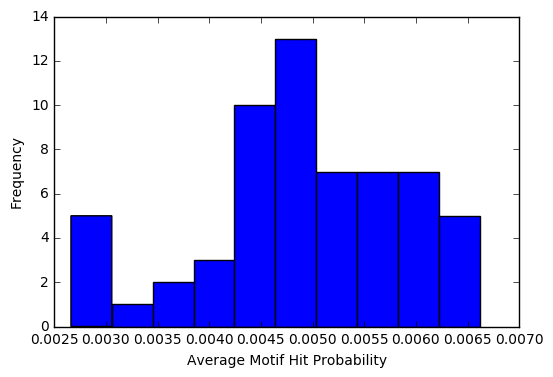

In [8]:
autoregulatory = ['ftz_up','ftz_zebra','gt_minus1']
percentiles = [5,25,50,75,95]
print 'AP Enhancer Average Motif Hit Probability Percentiles:'
for p in percentiles:
    print '%sth percentile: %s' %(p,np.percentile(od_av_ap_enhancer_IC.values(),p))
print 'Autoregulatory Enhancer Average Motif Hit Probability:'
for enhancer in autoregulatory:
    print '%s: %s' %(enhancer,od_av_ap_enhancer_IC[enhancer])
plt.hist(od_av_ap_enhancer_IC.values(), bins = 10)
plt.xlabel('Average Motif Hit Probability')
plt.ylabel('Frequency')
plt.show()

In [9]:
stats.mannwhitneyu(od_len_ap_enhancer.values(),od_len_dv_enhancer.values()) # Enhancer Length

MannwhitneyuResult(statistic=706.0, pvalue=0.00045134118354578763)

In [31]:
print 'The median AP enhancer length is %s bp' %np.percentile(od_len_ap_enhancer.values(),50)
print 'The median DV enhancer length is %s bp' %np.percentile(od_len_dv_enhancer.values(),50)

The median AP enhancer length is 1289.0 bp
The median DV enhancer length is 800.0 bp


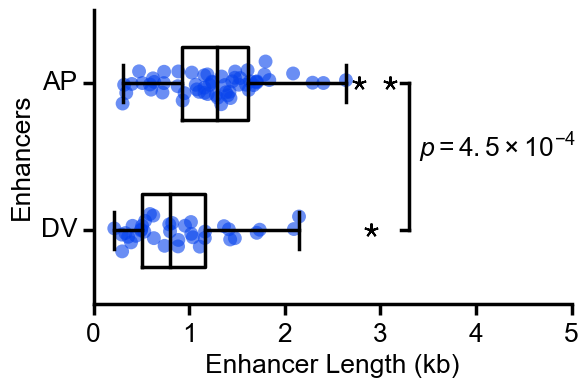

In [18]:
## Figure 2A: AP vs DV Enhancer Length Distributions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

# Plot boxplots of distributions
bp = plt.boxplot([[float(_)/1000 for _ in od_len_dv_enhancer.values()],[float(_)/1000 for _ in od_len_ap_enhancer.values()]],0,'rs',0,widths = (0.5,0.5)) #,showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Plot all data points except outliers
x1 = [float(_)/1000 for _ in list(set(od_len_dv_enhancer.values())-set([float(_)*1000 for _ in bp['fliers'][0].get_xdata()]))]
y = np.random.normal(1, 0.06, size=len(x1)) # add jitter
plt.scatter(x1, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))
x2 = [float(_)/1000 for _ in list(set(od_len_ap_enhancer.values())-set([float(_)*1000 for _ in bp['fliers'][1].get_xdata()]))]
y = np.random.normal(2, 0.06, size=len(x2)) # add jitter
plt.scatter(x2, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

# Add the p-value on the side
ax1.plot([3.3,3.3],[1,2],'k-',linewidth=lw)
ax1.plot([3.22,3.3],[2,2],'k-',linewidth=lw)
ax1.plot([3.22,3.3],[1,1],'k-',linewidth=lw)
ax1.text(3.4,1.5, r'$p= 4.5 \times 10^{-4}$', fontsize=font[2])

# Set x limits
ax1.set_xlim([0, 5])

# Add x-,y-labels
plt.xlabel('Enhancer Length (kb)',fontsize=font[2])
plt.ylabel('Enhancers',fontsize=font[2])

# Set y-ticks
plt.yticks([1,2], ['DV','AP'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2A-AP-DV Enhancer Length BOXPLOT.svg',transparent=True)

In [10]:
stats.mannwhitneyu(od_ap_enhancer_nTFs.values(),od_dv_enhancer_nTFs.values()) # number of TFBSs

MannwhitneyuResult(statistic=139.5, pvalue=1.5009580106182933e-13)

In [32]:
print 'The median number of TF binding sites in AP enhancers is %s.' %np.percentile(od_ap_enhancer_nTFs.values(),50)
print 'The median number of TF binding sites in DV enhancers is %s.' %np.percentile(od_dv_enhancer_nTFs.values(),50)

The median number of TF binding sites in AP enhancers is 47.0.
The median number of TF binding sites in DV enhancers is 9.0.


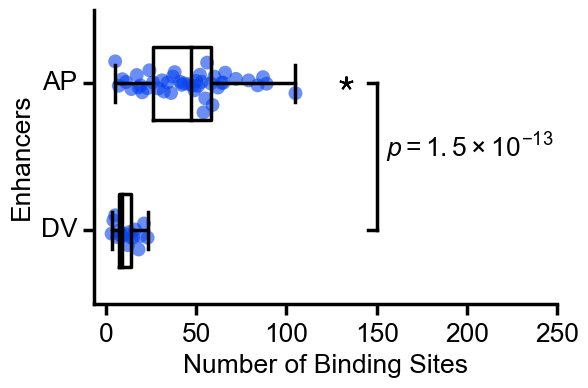

In [28]:
## Figure 2B: AP vs DV Number of TFBSs Distributions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

# Plot boxplots of distributions
bp = plt.boxplot([[float(_) for _ in od_dv_enhancer_nTFs.values()],[float(_) for _ in od_ap_enhancer_nTFs.values()]],0,'rs',0,widths = (0.5,0.5)) #,showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Plot all data points except outliers
x1 = [float(_) for _ in list(set(od_dv_enhancer_nTFs.values())-set([float(_) for _ in bp['fliers'][0].get_xdata()]))]
y = np.random.normal(1, 0.06, size=len(x1)) # add jitter
plt.scatter(x1, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))
x2 = [float(_) for _ in list(set(od_ap_enhancer_nTFs.values())-set([float(_) for _ in bp['fliers'][1].get_xdata()]))]
y = np.random.normal(2, 0.06, size=len(x2)) # add jitter
plt.scatter(x2, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

# Add the p-value on the side
ax1.plot([150,150],[1,2],'k-',linewidth=lw)
ax1.plot([145,150],[2,2],'k-',linewidth=lw)
ax1.plot([145,150],[1,1],'k-',linewidth=lw)
ax1.text(155,1.5,r'$p= 1.5 \times 10^{-13}$', fontsize=font[2])

# Set x limits
ax1.set_xlim([-7, 250])

# Add x-,y-labels
plt.xlabel('Number of Binding Sites',fontsize=font[2])
plt.ylabel('Enhancers',fontsize=font[2])

# Set y-ticks
plt.yticks([1,2], ['DV','AP'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2B-AP-DV Number of TFBSs BOXPLOT.svg',transparent=True)

In [11]:
stats.mannwhitneyu([float(_)/len(AP_DV_TFs['DV']) for _ in od_dv_enhancer_nTFs.values()],[float(_)/len(AP_DV_TFs['AP']) for _ in od_ap_enhancer_nTFs.values()]) 

MannwhitneyuResult(statistic=540.0, pvalue=6.1429658124831132e-06)

In [33]:
print 'The median number of TF binding sites per AP TF expressed is %s.' %np.percentile([float(_)/len(AP_DV_TFs['AP']) for _ in od_ap_enhancer_nTFs.values()],50)
print 'The median number of TF binding sites per DV TF expressed is %s.' %np.percentile([float(_)/len(AP_DV_TFs['DV']) for _ in od_dv_enhancer_nTFs.values()],50)

The median number of TF binding sites per AP TF expressed is 2.04347826087.
The median number of TF binding sites per DV TF expressed is 0.9.


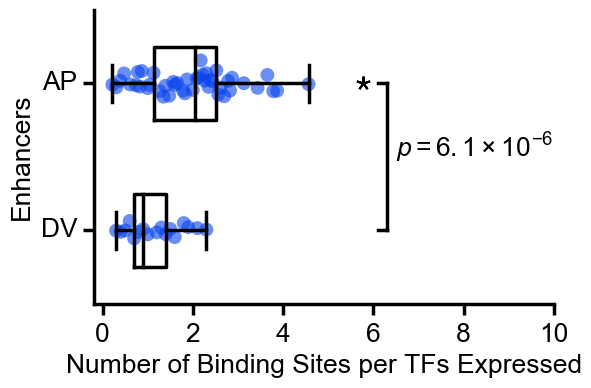

In [12]:
## Figure 2C: AP vs DV Number of TFBSs per TFs Expressed Distributions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

# Plot boxplots of distributions
bp = plt.boxplot([[float(_)/len(AP_DV_TFs['DV']) for _ in od_dv_enhancer_nTFs.values()],[float(_)/len(AP_DV_TFs['AP']) for _ in od_ap_enhancer_nTFs.values()]],0,'rs',0,widths = (0.5,0.5)) #,showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Plot all data points except outliers
x1 = list(set([float(_)/len(AP_DV_TFs['DV']) for _ in od_dv_enhancer_nTFs.values()])-set(bp['fliers'][0].get_xdata()))
y = np.random.normal(1, 0.06, size=len(x1)) # add jitter
plt.scatter(x1, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))
x2 = list(set([float(_)/len(AP_DV_TFs['AP']) for _ in od_ap_enhancer_nTFs.values()])-set(bp['fliers'][1].get_xdata()))
y = np.random.normal(2, 0.06, size=len(x2)) # add jitter
plt.scatter(x2, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

# Add the p-value on the side
ax1.plot([6.3,6.3],[1,2],'k-',linewidth=lw)
ax1.plot([6.1,6.3],[2,2],'k-',linewidth=lw)
ax1.plot([6.1,6.3],[1,1],'k-',linewidth=lw)
ax1.text(6.5,1.5,r'$p= 6.1 \times 10^{-6}$', fontsize=font[2])

# Set x limits
ax1.set_xlim([-0.2, 10])

# Add x-,y-labels
plt.xlabel('Number of Binding Sites per TFs Expressed',fontsize=font[2])
plt.ylabel('Enhancers',fontsize=font[2])

# Set y-ticks
plt.yticks([1,2], ['DV','AP'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2C-AP-DV Number of TFBSs per TFs Expressed BOXPLOT.svg',transparent=True)

In [13]:
#Create lists of motif hit probabilities for AP/DV TFs
axis_prob = []
for k,v in AP_DV_TFs.iteritems():
    for tf in v:
        if tf not in IC.keys():
            AP_DV_TFs[k].remove(tf)
    axis_prob.append([np.power(2,-IC[x]) for x in AP_DV_TFs[k]])

stats.mannwhitneyu(axis_prob[0],axis_prob[1]) # motif hit probabilities

MannwhitneyuResult(statistic=97.0, pvalue=0.24650535064391116)

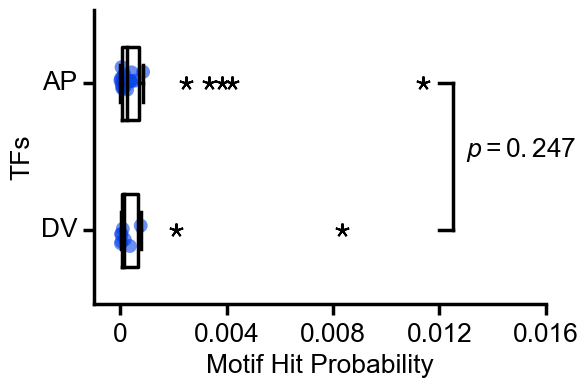

In [24]:
## Figure 2D: AP vs DV TFs Motif Hit Probability Distributions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

# Plot boxplots of distributions
bp = plt.boxplot([axis_prob[0],axis_prob[1]],0,'rs',0,widths = (0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Plot all data points except outliers
x1 = list(set(axis_prob[0])-set(bp['fliers'][0].get_xdata())) # plot all data except outliers
y = np.random.normal(1, 0.06, size=len(x1)) # add jitter
plt.scatter(x1, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))
x2 = list(set(axis_prob[1])-set(bp['fliers'][1].get_xdata()))
y = np.random.normal(2, 0.06, size=len(x2)) # add jitter
plt.scatter(x2, y, s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

# Add the p-value on the side
ax1.plot([0.0125,0.0125],[1,2],'k-',linewidth=lw)
ax1.plot([0.012,0.0125],[2,2],'k-',linewidth=lw)
ax1.plot([0.012,0.0125],[1,1],'k-',linewidth=lw)
ax1.text(0.013,1.5,r'$p= 0.247$', fontsize=font[2])

# Set x limits
ax1.set_xlim([-0.001, 0.016])

# Add x-,y-labels
plt.xlabel('Motif Hit Probability',fontsize=font[2])
plt.ylabel('TFs',fontsize=font[2])

# Set x-,y-ticks
plt.xticks([0,0.004,0.008,0.012,0.016,], ['0','0.004','0.008','0.012','0.016'])
plt.yticks([1,2], ['DV','AP'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2D-Information Content of AP-DV TFs BOXPLOT.svg',transparent=True)

In [14]:
stats.mannwhitneyu(od_av_ap_enhancer_IC.values(),od_av_dv_enhancer_IC.values()) # average motif hit probability

MannwhitneyuResult(statistic=363.0, pvalue=7.4939153313629304e-09)

In [34]:
print 'The median number motif hit probability in AP enhancers is %s.' %np.percentile(od_av_ap_enhancer_IC.values(),50)
print 'The median number motif hit probability in DV enhancers is %s.' %np.percentile(od_av_dv_enhancer_IC.values(),50)

The median number motif hit probability in AP enhancers is 0.00493229600655.
The median number motif hit probability in DV enhancers is 0.00301386643665.


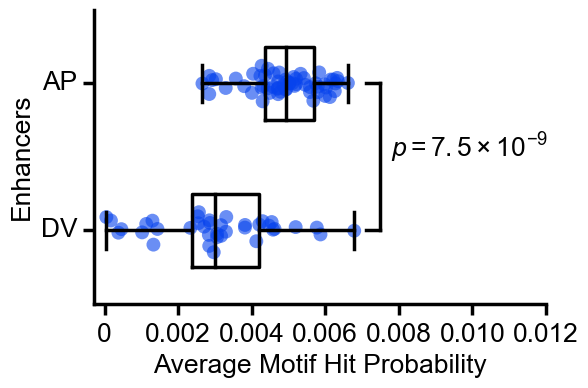

In [30]:
## Plot Figure 2E: AP vs DV Average Motif Hit Probability Distributions
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(13/adj)]
lw = 2.5

fig, ax1 = plt.subplots()

# Plot boxplots of distributions
bp = plt.boxplot([od_av_dv_enhancer_IC.values(),od_av_ap_enhancer_IC.values()],0,'rs',0,widths = (0.5,0.5)) #,showfliers=False)
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),color='blue',ms=10,mew=1.5)
plt.setp(bp['medians'], color='black',linewidth = lw)

# Plot all data points except outliers
x = list(set(od_av_dv_enhancer_IC.values())-set(bp['fliers'][0].get_xdata()))
y = np.random.normal(1, 0.06, size=len(x)) # add jitter
plt.scatter(x, y,s=100,alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))
x = list(set(od_av_ap_enhancer_IC.values())-set(bp['fliers'][1].get_xdata()))
y = np.random.normal(2, 0.06, size=len(x)) # add jitter
plt.scatter(x, y,s=100,alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

# Add the p-value on the side
ax1.plot([0.0075,0.0075],[1,2],'k-',linewidth=lw)
ax1.plot([0.0071,0.0075],[2,2],'k-',linewidth=lw)
ax1.plot([0.0071,0.0075],[1,1],'k-',linewidth=lw)
ax1.text(0.0078,1.5,r'$p=7.5\times10^{-9}$', fontsize=font[2])

# Set x limits
ax1.set_xlim([-0.0003, 0.012])

# Add x-,y-labels
plt.xlabel('Average Motif Hit Probability',fontsize=font[2])
plt.ylabel('Enhancers',fontsize = font[2])

# Set x-,y-ticks
plt.xticks([0,0.002,0.004,0.006,0.008,0.01,0.012], ['0','0.002','0.004','0.006','0.008','0.010','0.012'])
plt.setp(ax1, yticklabels=['DV','AP'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2E-AP-DV Average Information Content BOXPLOT.svg',transparent=True)

In [26]:
## Section 5b: Analyze minVT enhancers - calculate length, number of binding sites, and av motif hit probability of enhancers
od_minVT_len_enhancer = createSeqIN(minVT_enhancers_ALL,0,0,os.getcwd(),'MinVT_enhancers_mel',1,0)
# run all TFs on all enhancers
runPatser(os.getcwd(),'MinVT_enhancers_mel',TF_stage_ALL)
minVT_patser_output = parsePatser(os.getcwd(),TF_stage_ALL,'MinVT_enhancers_mel',lnp_cutoff,'MinVT',perc,'.txt')
# minVT_patser_output_nd = pd.read_csv('patserAnalysis/MinVT_enhancers_patser_output_noduplicates_fromHPC.txt',index_col=0)

Done: gt
Done: CG8319
Done: CG18599
Done: Lmx1a
Done: GATAd
Done: GATAe
Done: Rx
Done: NK7.1
Done: Sidpn
Done: ttk
Done: otp
Done: sima
Done: CG15696
Done: su(Hw)
Done: sim
Done: Hr39
Done: gl
Done: CG9876
Done: CG11504
Done: slou
Done: Hr4
Done: Sp1
Done: jim
Done: Vsx1
Done: byn
Done: Eip75B
Done: tj
Done: Vsx2
Done: Mitf
Done: sens
Done: sens-2
Done: Atf6
Done: Cf2
Done: unpg
Done: CG5953
Done: Dref
Done: bin
Done: Ets21C
Done: D
Done: disco-r
Done: nau
Done: E(spl)m5-HLH
Done: da
Done: repo
Done: CG4360
Done: bcd
Done: opa
Done: CG3407
Done: rn
Done: Hr83
Done: zld
Done: crp
Done: E(spl)mbeta-HLH
Done: bap
Done: vis
Done: gsb-n
Done: fd64A
Done: eve
Done: disco
Done: crc
Done: grh
Done: pan
Done: Spps
Done: h
Done: amos
Done: dpn
Done: Myc
Done: Hnf4
Done: shn
Done: en
Done: Poxn
Done: Poxm
Done: ss
Done: jigr1
Done: eg
Done: CG4854
Done: abd-A
Done: sage
Done: Dll
Done: ara
Done: crol
Done: ey
Done: Oli
Done: CG33557
Done: E(spl)m7-HLH
Done: btn
Done: nub
Done: PHDP
Done: sug
Done

In [42]:
# Calculate minVt enhancer length and export to file
len_minVT_enhancer = {}
for stage,enhancers in minVT_enhancers.iteritems():
    len_minVT_enhancer[stage] = {}
    for enhancer in enhancers:
        len_minVT_enhancer[stage][enhancer]=od_minVT_len_enhancer[enhancer]
    len_minVT_enhancer[stage] = collections.OrderedDict(sorted(len_minVT_enhancer[stage].items(),key=lambda t:t[0]))
    dictionaryExport(len_minVT_enhancer[stage],'patserAnalysis/MinVT_enhancers_mel_len_stage%s.txt' %stage,0)

In [49]:
# Calculate the number of binding sites and av motif hit probability of enhancers
import time
minVT_patser_output = pd.read_csv('patserAnalysis/MinVT_enhancers_patser_output_aligned75.txt',sep='\t')
minVT_patser_output.columns = ['enhancer','tf','position','score','lnp']
minVT_patser_output[['score','lnp']] = minVT_patser_output[['score','lnp']].astype(float)

Stage = ['4_6','7_8','9_10','11_12','13_16']
od_av_minVT_enhancer_IC, od_minVT_enhancer_nTFs, od_minVT_enhancer_TF_counts = [],[],[]
for i in range(len(minVT_enhancers)):
    start = time.time()
    temp_av_IC, temp_nTFs, temp_TF_counts \
     = PatserAnalysis(minVT_patser_output,minVT_enhancers[Stage[i]],TF_stage[Stage[i]],heterodimers,IC)
    od_av_minVT_enhancer_IC.append(temp_av_IC)
    od_minVT_enhancer_nTFs.append(temp_nTFs)
    od_minVT_enhancer_TF_counts.append(temp_TF_counts)
    dictionaryExport(od_av_minVT_enhancer_IC[i],'patserAnalysis/MinVT_enhancers_mel_avIC_stage%s.txt' %Stage[i],0)
    dictionaryExport(od_minVT_enhancer_nTFs[i],'patserAnalysis/MinVT_enhancers_mel_nTFs_stage%s.txt' %Stage[i],0)
    od_minVT_enhancer_TF_counts[i].to_csv('patserAnalysis/MinVT_enhancers_mel_TFcounts_stage%s.txt' %Stage[i])    
    end = time.time()
    print(end - start)

53.4836909771
60.2325279713
109.866906881
205.995079041
282.823422909


In [18]:
# Read in patserAnalysis for minVT enhancers
Stage = ['4_6','7_8','9_10','11_12','13_16']
len_minVT_enhancer, od_av_minVT_enhancer_IC, od_minVT_enhancer_nTFs = {},[],[]
for stage in Stage:
    len_minVT_enhancer[stage] = dictionaryImport('patserAnalysis/MinVT_enhancers_mel_len_stage%s.txt' %stage,1)
    od_av_minVT_enhancer_IC.append(dictionaryImport('patserAnalysis/MinVT_enhancers_mel_avIC_stage%s.txt' %stage,1))
    od_minVT_enhancer_nTFs.append(dictionaryImport('patserAnalysis/MinVT_enhancers_mel_nTFs_stage%s.txt' %stage,1))

In [19]:
# Number of Active minVT Enhancers Across Embryogenesis
Stage = ['4_6','7_8','9_10','11_12','13_16']
for stage in Stage:
    print stage,len(minVT_enhancers[stage])

4_6 713
7_8 878
9_10 1530
11_12 2307
13_16 3334


In [20]:
# Number of TFs Expressed Across Embryogenesis
for stage in Stage:
    print stage,len(TF_stage[stage])

4_6 216
7_8 202
9_10 219
11_12 265
13_16 276


In [21]:
# Total Number of TFs Involved in Embryogenesis
for stage in Stage:
    TF_stage_ALL = TF_stage_ALL + TF_stage[stage]
len(set(TF_stage_ALL))

292

In [22]:
# Median minVT Enhancer Length Across Embryogenesis
for stage in Stage:
    print stage,np.percentile(len_minVT_enhancer[stage].values(),50)

4_6 545.0
7_8 542.5
9_10 462.0
11_12 432.0
13_16 404.0


In [23]:
# Median Number of TF binding sites in minVT Enhancers Across Embryogenesis
for i in range(5):
    print Stage[i],np.percentile(od_minVT_enhancer_nTFs[i].values(),50)

4_6 154.0
7_8 140.5
9_10 132.0
11_12 153.0
13_16 151.0


In [24]:
# Median Number of TF binding sites in minVT Enhancers per TFs Expressed Across Embryogenesis
Stage = ['4_6','7_8','9_10','11_12','13_16']
for i in range(5):
    print Stage[i],np.percentile(od_minVT_enhancer_nTFs[i].values(),50)/len(TF_stage[Stage[i]])

4_6 0.712962962963
7_8 0.695544554455
9_10 0.602739726027
11_12 0.577358490566
13_16 0.547101449275


In [25]:
# Median Average Motif Hit Probability Across Embryogenesis
for i in range(5):
    print Stage[i],np.percentile(od_av_minVT_enhancer_IC[i].values(),50)

4_6 0.0067254547
7_8 0.0067101857
9_10 0.0064075419
11_12 0.0069682629
13_16 0.00699305625


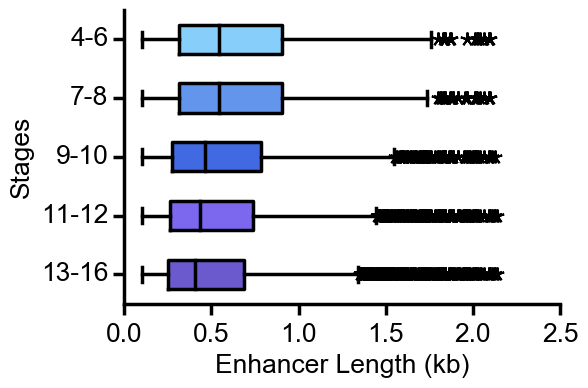

In [57]:
## Figure 2F: minVT Enhancer Length Boxplots
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

x = []
for i in ['13_16','11_12','9_10','7_8','4_6']:
    x.append([float(_)/1000 for _ in len_minVT_enhancer[i].values()])
    
# Plot boxplots of the distributions
bp = plt.boxplot(x,0,'rs',0,widths = (0.5,0.5,0.5,0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Color in the boxplots
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(5):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[i])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    plt.plot(med.get_xdata(), med.get_ydata(), 'k')

# Add x-,y-labels
plt.xlabel('Enhancer Length (kb)',fontsize=font[2])
plt.ylabel('Stages',fontsize=font[2])

# Set y-ticks
plt.yticks(range(1,6), ['13-16','11-12','9-10','7-8','4-6'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2F-minVT enhancer length BOXPLOT.svg',transparent=True)

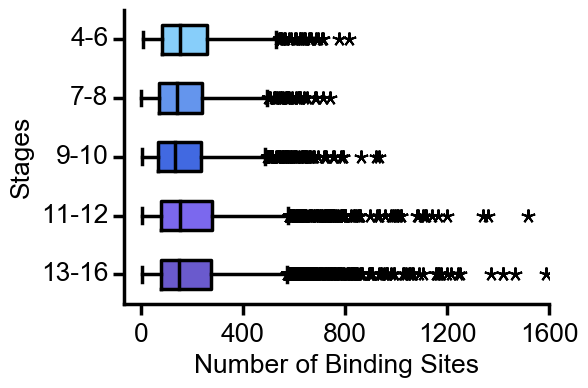

In [58]:
## Figure 2G: Number of TFBSs Boxplots
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

fig, ax1 = plt.subplots()

x = []
for i in [4,3,2,1,0]:
    x.append([float(_)/1 for _ in od_minVT_enhancer_nTFs[i].values()])

# Plot boxplots of the distributions
bp = plt.boxplot(x,0,'rs',0,widths = (0.5,0.5,0.5,0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Color in the boxplots
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(5):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[i])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    plt.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x limits
ax1.set_xlim([-65, 1600])

# Add x-,y-labels
plt.xlabel('Number of Binding Sites',fontsize=font[2])
plt.ylabel('Stages',fontsize=font[2])

# Set x-,y-ticks
plt.xticks([0,400,800,1200,1600], ['0','400','800','1200','1600'])
plt.yticks(range(1,6), ['13-16','11-12','9-10','7-8','4-6'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2G-minVT Number of TFBSs BOXPLOT.svg',transparent=True)

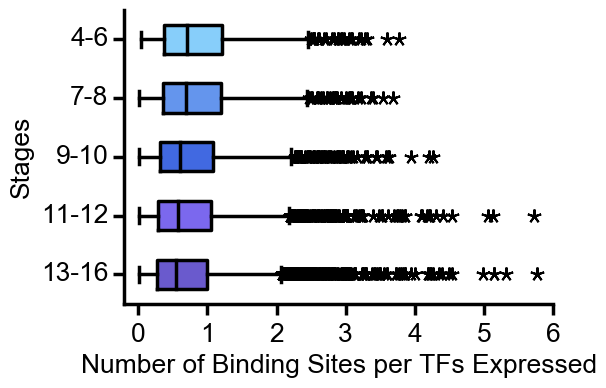

In [59]:
## Figure 2H: minVT Number of Binding Sites per TF Expressed
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

fig, ax1 = plt.subplots()

Stage = ['4_6','7_8','9_10','11_12','13_16']
x = []
for i in [4,3,2,1,0]:
    x.append([float(v)/len(TF_stage[Stage[i]]) for v in od_minVT_enhancer_nTFs[i].values()])

# Plot boxplots of distributions
bp = plt.boxplot(x,0,'rs',0,widths = (0.5,0.5,0.5,0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Color in boxplots
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(5):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[i])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    plt.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x limits
ax1.set_xlim([-0.2, 6])

# Add x-,y-labels
plt.xlabel('Number of Binding Sites per TFs Expressed',fontsize=font[2])
plt.ylabel('Stages',fontsize=font[2])

# Set y-ticks
plt.yticks(range(1,6), ['13-16','11-12','9-10','7-8','4-6'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2H-minVT number of BS per TF expressedBOXPLOT.svg',transparent=True)

In [60]:
for i in range(5):
    print Stage[i],np.percentile(x[4-i],50)

4_6 0.712962962963
7_8 0.695544554455
9_10 0.602739726027
11_12 0.577358490566
13_16 0.547101449275


In [61]:
x = []
for i in [4,3,2,1,0]:
    x.append([float(v)/len(TF_stage[Stage[i]]) for v in od_minVT_enhancer_nTFs[i].values()])

pvalues = []
Stage = ['4_6','7_8','9_10','11_12','13_16']
for i in range(5):
    pvalues.append([10*stats.mannwhitneyu(x[i],x[j])[1] for j in range(5)])

for i in range(5):
    for pval,j in zip(pvalues[i],range(5)):
        if pval > 1:
            pvalues[i][j] = 1 
        pvalues[i][j] = pvalues[i][j]
pvalues = np.array(pvalues) 

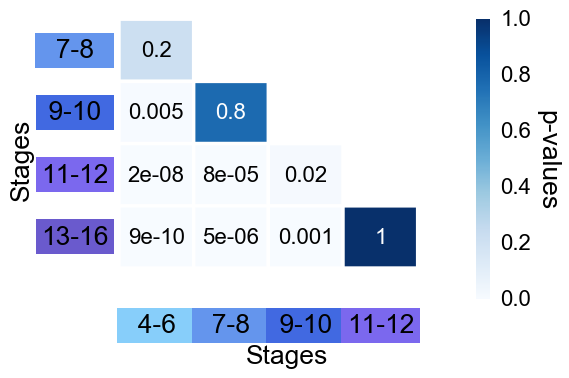

In [62]:
## Figure 2K: Heatmap of p-values for pair-wise comparisons of minVT Number of Binding Sites per TF Expressed
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj),math.floor(10/adj)]
lw = 2.5

fig,ax1 = plt.subplots()

mask = np.triu(pvalues, k=0)
pvalues2mask = np.ma.array(pvalues, mask=mask)[1:,:-1]
# Plot heatmap of p-values
heatmap = ax1.pcolor(pvalues2mask,cmap=plt.cm.Blues,edgecolors='w', linewidths=lw)
ax1.invert_yaxis()

# Add p-value to box
for y in range(pvalues2mask.shape[0]):
    for x in range(pvalues2mask.shape[1]):
        if pvalues2mask[y,x] > 0.5:
            col = 'w' # use white text if box color is dark
        else:
            col = 'k' # use black text if box color is light
        if pvalues2mask[y,x]!='--':
            plt.text(x + 0.5, y + 0.5, '%.1g' %pvalues2mask[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=16, color = col)

# Set x-,y-ticks
ax1.set_yticks(np.arange(pvalues.shape[0])+0.5, minor=False)
ax1.set_xticks(np.arange(pvalues.shape[1])+0.5, minor=False)

# Set x-,y-tick labels
ax1.set_yticklabels(['  7-8  ',' 9-10 ','11-12','13-16'], minor=False,fontsize=font[2])
ax1.set_xticklabels(['  4-6  ','  7-8  ',' 9-10 ','11-12'], minor=False,fontsize=font[2])

# Adjust tick parameters
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right='off',
    left='off',
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

# Add x-,y-labels
ax1.set_xlabel('Stages',fontsize=font[2])
ax1.set_ylabel('Stages',fontsize=font[2])

# Color x-,y-labels
xlabel = ax1.xaxis.get_ticklabels()
for i in range(len(xlabel)):
    xlabel[i].set_bbox(dict(facecolor=boxColors[::-1][i],edgecolor='none'))
ylabel = ax1.yaxis.get_ticklabels()
for i in range(4):
    ylabel[i].set_bbox(dict(facecolor=boxColors[::-1][i+1],edgecolor='none'))

# Add colorbar
heatmap.set_clim(0,1) # set colorbar limits
cb = plt.colorbar(heatmap)
cb.outline.set_visible(False)
cb.set_ticks(np.linspace(0,1,6), update_ticks=True)
cb.set_ticklabels(np.linspace(0,1,6), update_ticks=True)
cb.ax.tick_params(labelsize=16,right='off')
cb.set_label('p-values',labelpad=20, rotation=270,fontsize = font[2])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)

plt.savefig('Figures/Figure2K-minVT nTFBSs per TF expressed pvalues.svg',transparent=True)

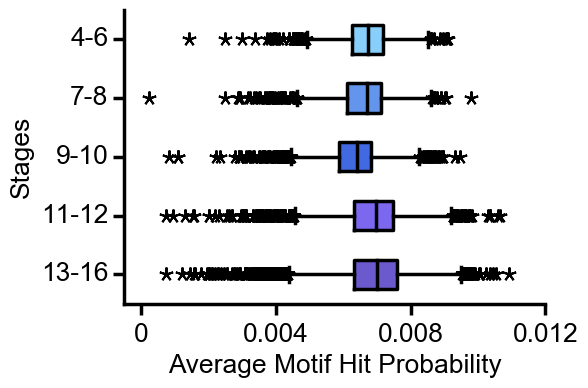

In [63]:
## Figure 2J: minVT Average Information Content Boxplots
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

fig, ax1 = plt.subplots()

x = []
for i in [4,3,2,1,0]:
    x.append([_ for _ in od_av_minVT_enhancer_IC[i].values()])

# Plot boxplots of distributions
bp = plt.boxplot(x,0,'rs',0,widths = (0.5,0.5,0.5,0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Color in the boxplots
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(5):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[i])
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    plt.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x limits
ax1.set_xlim([-0.0005, 0.012])

# Add x-,y-labels
plt.xlabel('Average Motif Hit Probability',fontsize=font[2])
plt.ylabel('Stages',fontsize=font[2])

# Set x-,y-ticks
plt.xticks([0,0.004,0.008,0.012], ['0','0.004','0.008','0.012'])
plt.yticks(range(1,6), ['13-16','11-12','9-10','7-8','4-6'])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

plt.savefig('Figures/Figure2I-minVT Motif Hit Probability BOXPLOT.svg',transparent=True)

In [64]:
pvalues = []
Stage = ['4_6','7_8','9_10','11_12','13_16']
for i in Stage:
#     pvalues.append(['%.2g; %.2g' %(stats.ks_2samp(len_minVT_enhancer[i].values(),len_minVT_enhancer[j].values())[1],stats.mannwhitneyu(len_minVT_enhancer[i].values(),len_minVT_enhancer[j].values())[1]) for j in Stage])
#     pvalues1.append([stats.ks_2samp(len_minVT_enhancer[i].values(),len_minVT_enhancer[j].values())[1] for j in Stage])
    pvalues.append([10*stats.mannwhitneyu(len_minVT_enhancer[i].values(),len_minVT_enhancer[j].values())[1] for j in Stage])

for i in range(5):
    for pval,j in zip(pvalues[i],range(5)):
        if pval > 1:
            pvalues[i][j] = 1 
        pvalues[i][j] = pvalues[i][j]
pvalues = np.array(pvalues)  

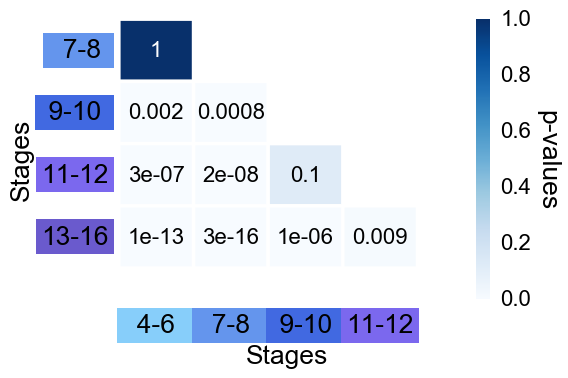

In [65]:
## Figure 2I: Heatmap of p-values for pair-wise comparisons of minVT Enhancer Length
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rc('axes', linewidth=2.5)
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj),math.floor(10/adj)]
lw = 2.5

fig,ax1 = plt.subplots()

mask = np.triu(pvalues, k=0)
pvalues2mask = np.ma.array(pvalues, mask=mask)[1:,:-1]
# Plot heatmap of p-values
heatmap = ax1.pcolor(pvalues2mask,cmap=plt.cm.Blues,edgecolors='w', linewidths=lw)
ax1.invert_yaxis()

# Add p-value to box
for y in range(pvalues2mask.shape[0]):
    for x in range(pvalues2mask.shape[1]):
        if pvalues2mask[y,x] > 0.5:
            col = 'w' # use white text if box color is dark
        else:
            col = 'k' # use black text if box color is light
        if pvalues2mask[y,x]!='--':
            plt.text(x + 0.5, y + 0.5, '%.1g' %pvalues2mask[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     fontsize=16, color = col)

# Set x-,y-ticks
ax1.set_yticks(np.arange(pvalues.shape[0])+0.5, minor=False)
ax1.set_xticks(np.arange(pvalues.shape[1])+0.5, minor=False)

# Set x-,y-tick labels
ax1.set_yticklabels(['  7-8 ',' 9-10 ','11-12','13-16'], minor=False,fontsize=font[2])
ax1.set_xticklabels(['  4-6  ','  7-8  ',' 9-10 ','11-12'], minor=False,fontsize=font[2])
    
# Adjust tick parameters
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right='off',
    left='off',
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

# Add x-,y-labels
ax1.set_xlabel('Stages',fontsize=font[2])
ax1.set_ylabel('Stages',fontsize=font[2])

# Color x-,y-labels
xlabel = ax1.xaxis.get_ticklabels()
for i in range(len(xlabel)):
#     xlabel[i].set_clip_box([[1, 2], [2, 3]])
    xlabel[i].set_bbox(dict(facecolor=boxColors[::-1][i],edgecolor='none'))#,boxstyle='round,pad=0.5'))
ylabel = ax1.yaxis.get_ticklabels()
for i in range(4):
    ylabel[i].set_bbox(dict(facecolor=boxColors[::-1][i+1],edgecolor='none'))#,boxstyle='round,pad=0.5'))

# Add colorbar
heatmap.set_clim(0,1) # set colorbar limits
cb = plt.colorbar(heatmap)
cb.outline.set_visible(False)
cb.set_ticks(np.linspace(0,1,6), update_ticks=True)
cb.set_ticklabels(np.linspace(0,1,6), update_ticks=True)
cb.ax.tick_params(labelsize=16,right='off')
cb.set_label('p-values',labelpad=20, rotation=270,fontsize = font[2])

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
plt.gcf().subplots_adjust(bottom=0.2)
plt.gcf().subplots_adjust(left=0.2)

plt.savefig('Figures/Figure2I-minVT enhancer length pvalues.svg',transparent=True)

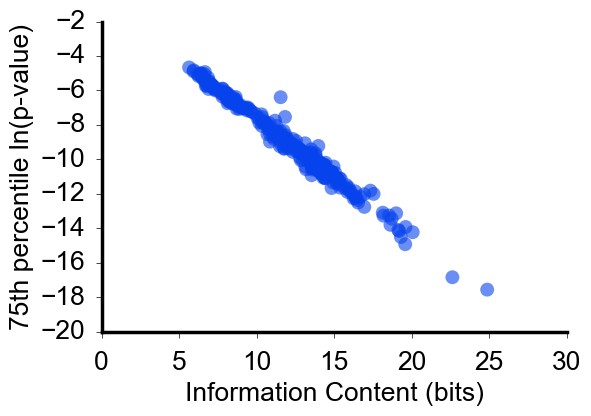

In [66]:
## Supplemental Figures
# Sanity check: information content should decrease with more significant ln(p-values)
fig, ax1 = plt.subplots()
x = [IC[_] for _ in IC.keys() if _ in lnp_cutoff.keys()]
y = [lnp_cutoff[_] for _ in IC.keys() if _ in lnp_cutoff.keys()]
plt.scatter(x,y,s = 100, alpha = 0.6, edgecolors = 'None', color=(0.02734, 0.2617, 0.92969))

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.tick_params(axis='both',which='major',direction='out',labelsize=font[2])


plt.xlabel('Information Content (bits)',fontsize=font[2])
plt.ylabel('75th percentile ln(p-value)',fontsize=font[2])
plt.savefig('Figures/FigureS2.svg')

In [68]:
## Repeat analysis of AP and DV enhancers while varying ln(p-value) cutoff
## Section 5a: Read in the patser output for the AP/DV enhancers and calculate number of binding sites and av info content of enhancers
od_len_ap_enhancer = createSeqIN(od_AP_enhancers,0,0,os.getcwd(),'AP_enhancers_mel',0,0)
od_len_dv_enhancer = createSeqIN(od_DV_enhancers,0,0,os.getcwd(),'DV_enhancers_mel',0,0)

# Set the ln(p-value) cutoff for determining real TFBSs
perc = 90
lnp_cutoff = dict(zip(lnp_data.keys(),[np.percentile(x,perc) for x in lnp_data.values()]))
# Save binding sites that have ln(p-value)s that satisfy the cutoff to dataframe
ap_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['AP'],'AP_enhancers_mel',lnp_cutoff,'AP',perc,'.txt')
dv_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['DV'],'DV_enhancers_mel',lnp_cutoff,'DV',perc,'.txt')
_, od_ap_enhancer_nTFs1, _ \
 = PatserAnalysis(ap_patser_output,'all',AP_DV_TFs['AP'],heterodimers,IC)
_, od_dv_enhancer_nTFs1, _ \
 = PatserAnalysis(dv_patser_output,'all',AP_DV_TFs['DV'],heterodimers,IC)
    
# Set the ln(p-value) cutoff for determining real TFBSs
perc = 95
lnp_cutoff = dict(zip(lnp_data.keys(),[np.percentile(x,perc) for x in lnp_data.values()]))
# Save binding sites that have ln(p-value)s that satisfy the cutoff to dataframe
ap_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['AP'],'AP_enhancers_mel',lnp_cutoff,'AP',perc,'.txt')
dv_patser_output = parsePatser(os.getcwd(),AP_DV_TFs['DV'],'DV_enhancers_mel',lnp_cutoff,'DV',perc,'.txt')
_, od_ap_enhancer_nTFs2, _ \
 = PatserAnalysis(ap_patser_output,'all',AP_DV_TFs['AP'],heterodimers,IC)
_, od_dv_enhancer_nTFs2, _ \
 = PatserAnalysis(dv_patser_output,'all',AP_DV_TFs['DV'],heterodimers,IC)

bcd
cad
fkh
gt
hkb
hb
kni
knrl
Kr
oc
tll
D
eve
ftz
h
opa
prd
run
slp1
slp2
sob
odd
bowl
da
dl
brk
Mad
Med
shn
sna
twi
zen
zen2
bcd
cad
fkh
gt
hkb
hb
kni
knrl
Kr
oc
tll
D
eve
ftz
h
opa
prd
run
slp1
slp2
sob
odd
bowl
da
dl
brk
Mad
Med
shn
sna
twi
zen
zen2


In [69]:
stats.mannwhitneyu(od_ap_enhancer_nTFs.values(),od_dv_enhancer_nTFs.values()) # number of BS: 75th percentile

MannwhitneyuResult(statistic=139.5, pvalue=1.5009580106182933e-13)

In [70]:
stats.mannwhitneyu(od_ap_enhancer_nTFs1.values(),od_dv_enhancer_nTFs1.values()) # number of BS: 90th percentile

MannwhitneyuResult(statistic=101.0, pvalue=9.818030537802698e-15)

In [71]:
stats.mannwhitneyu(od_ap_enhancer_nTFs2.values(),od_dv_enhancer_nTFs2.values()) # number of BS: 95th percentile

MannwhitneyuResult(statistic=110.0, pvalue=1.6239674098353408e-14)

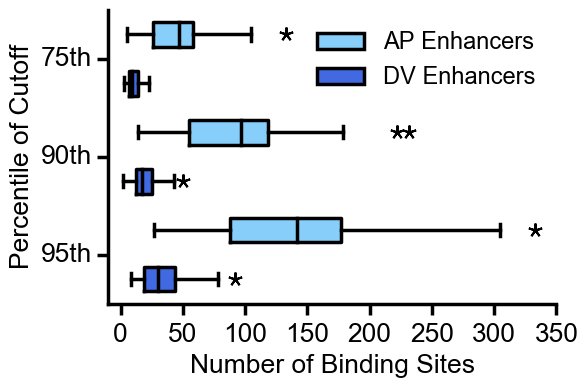

In [72]:
## For 3 different cutoffs, AP vs DV Number of TFBSs Boxplots (all on one graph)
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

fig, ax1 = plt.subplots()

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

x = [od_dv_enhancer_nTFs2.values(),od_ap_enhancer_nTFs2.values(),od_dv_enhancer_nTFs1.values(),od_ap_enhancer_nTFs1.values(),od_dv_enhancer_nTFs.values(),od_ap_enhancer_nTFs.values()]
# Plot boxplots of the distributions
bp = plt.boxplot(x,0,'rs',0,widths = (0.5,0.5,0.5,0.5,0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Color in the boxplots
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(6):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    if i % 2 == 0:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[2])
    else:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[4])        
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    plt.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x limits
ax1.set_xlim([-10, 350])

# Add x-,y-labels
plt.xlabel('Number of Binding Sites',fontsize=font[2])
plt.ylabel('Percentile of Cutoff',fontsize=font[2])

# Set x-,y-ticks
plt.yticks([1.5,3.5,5.5], ['95th','90th','75th'])

# Add Legend
dv = mpl.patches.Patch(edgecolor='black',facecolor='royalblue',linewidth=lw, label='dv') # Add patches to create boxes in legend
ap = mpl.patches.Patch(edgecolor='black',facecolor='lightskyblue',linewidth=lw, label='ap')
plt.legend((ap, dv),('AP Enhancers', 'DV Enhancers'),frameon=False,fontsize=font[3])
dv.set_visible(False)
ap.set_visible(False)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
plt.tick_params(axis='both',which='major',labelsize=font[2],direction='out',width=2.5,length=8)
plt.tight_layout()

# plt.savefig('Figures/FigureS1-Multiple_cutoffs.svg',transparent=True)

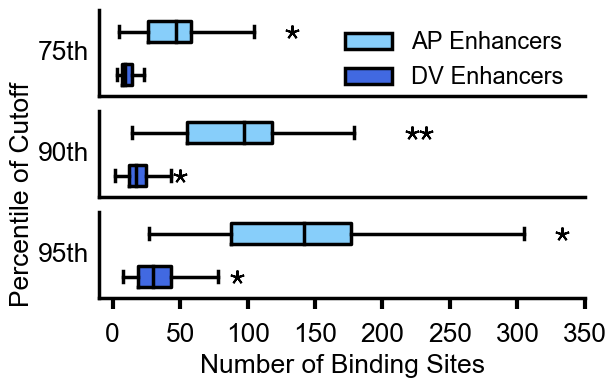

In [73]:
## For 3 different cutoffs, AP vs DV Number of TFBSs Boxplots (subplotted)
font = {'family' : 'Arial'}
mpl.rc('font', **font)  # pass in the font dict as kwargs
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams['mathtext.it'] = 'Arial:italic'
mpl.rcParams['mathtext.bf'] = 'Arial:bold'
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rc('ytick.major', pad=7.5)
mpl.rc('xtick.major', pad=10)

adj = 0.804
font = [math.floor(22/adj),math.floor(20/adj),math.floor(16/adj),math.floor(14/adj)]
lw = 2.5

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(top='off',bottom='off',left='off',right='off')
ax.set_xticks([])
ax.set_yticks([])

ax1 = fig.add_subplot(3,1,1)
ax1.set_xlim([-10, 350])

ax2 = fig.add_subplot(3,1,2)
ax2.set_xlim([-10, 350])

ax3 = fig.add_subplot(3,1,3)
ax3.set_xlim([-10, 350])

# Subplot 1
# Plot boxplots of the distributions
bp = ax1.boxplot([od_dv_enhancer_nTFs.values(),od_ap_enhancer_nTFs.values()],0,'rs',0,widths = (0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Add colors to boxes
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(2):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    if i % 2 == 0:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[2])
    else:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[4])        
    ax1.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    ax1.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x-,y-ticks
ax1.set_yticks([1.5])

# Set x-,y-tick labels
ax1.set_xticklabels([])
ax1.set_yticklabels(['75th'],fontsize=font[2])
ax1.tick_params(axis='both', which='both',length=0)
ax1.tick_params(top='off')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Subplot 2
# Plot boxplots of the distributions
bp = ax2.boxplot([od_dv_enhancer_nTFs1.values(),od_ap_enhancer_nTFs1.values()],0,'rs',0,widths = (0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Add colors to boxes
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(2):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    if i % 2 == 0:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[2])
    else:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[4])        
    ax2.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    ax2.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x-,y-ticks
ax2.set_yticks([1.5])

# Set x-,y-tick labels
ax2.set_xticklabels([])
ax2.set_yticklabels(['90th'],fontsize=font[2])
ax2.tick_params(axis='both', which='both',length=0)
ax2.tick_params(top='off')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Subplot 3
# Plot boxplots of the distributions
bp = ax3.boxplot([od_dv_enhancer_nTFs2.values(),od_ap_enhancer_nTFs2.values()],0,'rs',0,widths = (0.5,0.5))
plt.setp(bp['boxes'], color='black',linewidth = lw)
plt.setp(bp['caps'], color='black',linewidth = lw)
plt.setp(bp['whiskers'], color='black',linestyle='-',linewidth = lw)
plt.setp(bp['fliers'], marker=(5,2,0),ms=10,mew=1.5,color='blue')
plt.setp(bp['medians'], color='black',linewidth = lw)

# Add colors to boxes
boxColors = ['slateblue','mediumslateblue','royalblue','cornflowerblue','lightskyblue']
for i in range(2):
    box = bp['boxes'][i]
    boxCoords = list(zip(box.get_xdata(),box.get_ydata()))
    if i % 2 == 0:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[2])
    else:
        boxPolygon = mpl.patches.Polygon(boxCoords, facecolor = boxColors[4])        
    ax3.add_patch(boxPolygon)
    # Now draw the median lines back over what we just filled in
    med = bp['medians'][i]
    ax3.plot(med.get_xdata(), med.get_ydata(), 'k')

# Set x-,y-ticks
ax3.set_yticks([1.5])

# Set x-,y-tick labels
ax3.set_yticklabels(['95th'],fontsize=font[2])
ax3.tick_params(axis='x', which='major', direction='out', width=3, length=8, labelsize=font[2])
ax3.tick_params(axis='y', which='both', length=0)
ax3.tick_params(top='off')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

# Add x-,y-labels
plt.xlabel('Number of Binding Sites',fontsize=font[2])
fig.text(0.0, 0.5, 'Percentile of Cutoff', ha='center', va='center', rotation='vertical',fontsize=font[2])

# Add Legend
dv = mpl.patches.Patch(edgecolor='black',facecolor='royalblue',linewidth=lw, label='dv')
ap = mpl.patches.Patch(edgecolor='black',facecolor='lightskyblue',linewidth=lw, label='ap')
ax1.legend((ap, dv),('AP Enhancers', 'DV Enhancers'),frameon=False,fontsize=font[3],loc='upper right')
dv.set_visible(False)
ap.set_visible(False)

plt.tight_layout()

plt.savefig('Figures/FigureS1-Multiple_cutoffs.svg',transparent=True)